In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.interpolate import LinearNDInterpolator
from torch_geometric.transforms import delaunay
from scipy.spatial import Delaunay
import cmocean
#import linear regression
from sklearn.linear_model import LinearRegression
import sys
sys.path.append('../../src')
from ice_graph.ice_graph import Ice_graph

In [2]:
sorted(os.listdir('../../../week_data'))[0]

'field_20230101T000000Z.npz'

In [3]:
#load files
files = sorted(os.listdir('../../../week_data'))[:]
file0 = dict(np.load('../../../week_data/' + sorted(os.listdir('../../../week_data'))[0]))
file_final = dict(np.load('../../../week_data/' + sorted(os.listdir('../../../week_data'))[-1]))
file_graphs = []
for file in files:
    try:
        file_graphs.append(dict(np.load('../../../week_data/' + file)))
    except:
        print(file)
len(files),len(file_graphs)

(337, 337)

In [76]:
c = ['lightcyan']*d0['t'].shape[0]
type(c)

list

[]

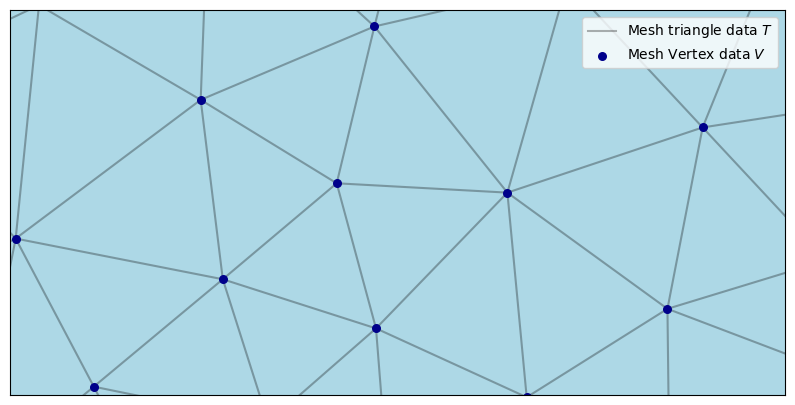

In [106]:
import matplotlib.tri as tri
fig,axs  = plt.subplots(1,1,figsize=(10,5))

#axs[0].scatter(d0['x'],d0['y'],s=10,c='lightblue', label='Mesh Vertex data' )

#get x,y in triangle center

#plot triangluation with only one color fill
#im = axs[0].triplot(d0['x'], d0['y'], d0['t'], c='k', alpha=0.8, label='Mesh triangle data')


# Plot triangulation with a different color for triangles
axs.triplot(d0['x'], d0['y'], d0['t'], color='k', alpha=0.3, label='Mesh triangle data $T$')  # Dark blue color for edges

axs.scatter(d0['x'], d0['y'], s=30, c='darkblue', label='Mesh Vertex data $V$')  # Light blue color for vertices
#set background color wiht label to '#ADD8E6'
axs.set_facecolor('#ADD8E6')

# Fill the triangles with a lighter blue color
axs.legend()
axs.set_xlim([1e6, 1.05e6])
axs.set_ylim([1e6, 1.025e6])
#remove xy labels
axs.set_xticks([])
axs.set_yticks([])


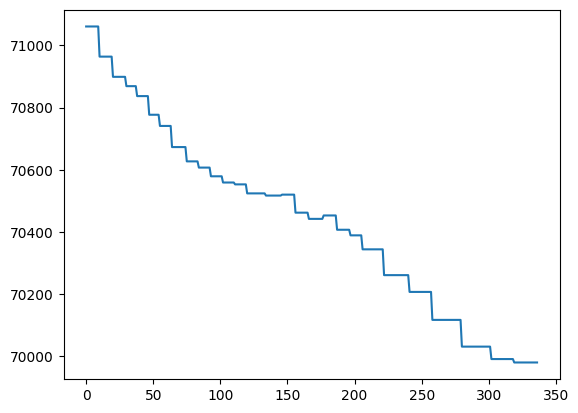

In [11]:
n_nodes  = []
for file in file_graphs:
    n_nodes.append(file['i'].shape[0])

plt.plot(n_nodes)

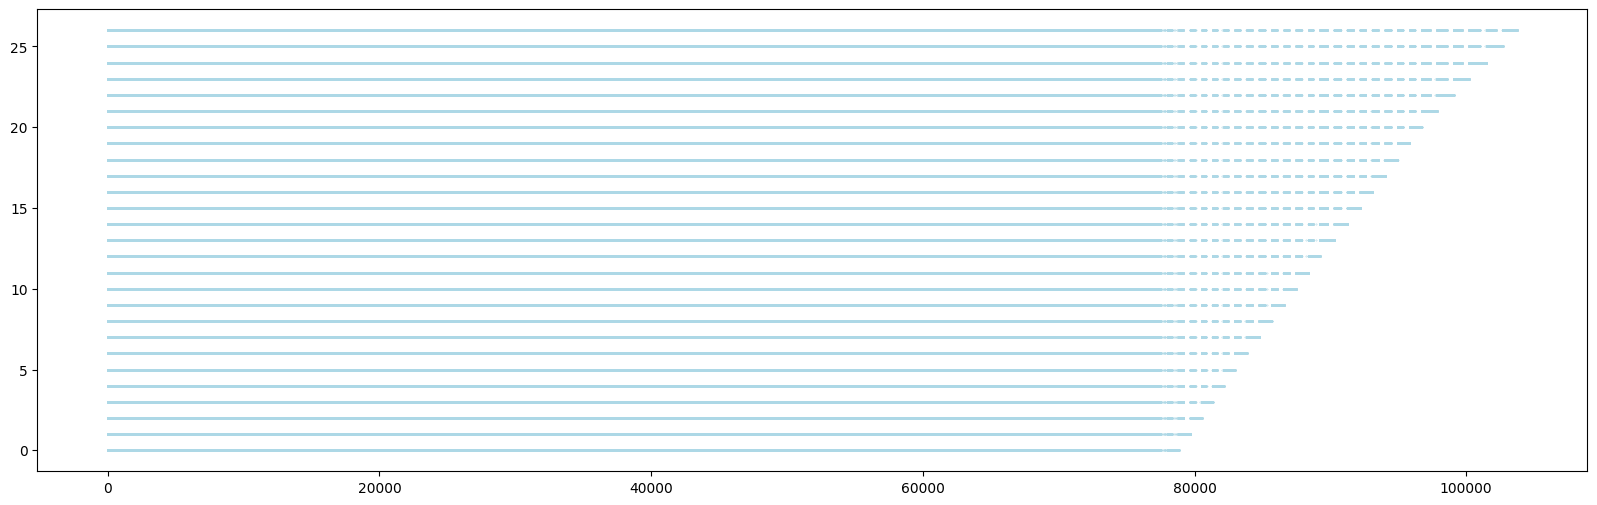

In [8]:
triangles = file_graphs[0]['t']
remeshed = []
for i,graph in enumerate(file_graphs):
    if graph['t'].shape != triangles.shape:
        remeshed.append(graph)
        triangles = graph['t']

plt.figure(figsize=(20,6))
for i,file in enumerate(remeshed):
    plt.scatter(file['i'],[i]*len(file['i']),s=.1,c='lightblue')


(850000.0, 1100000.0)

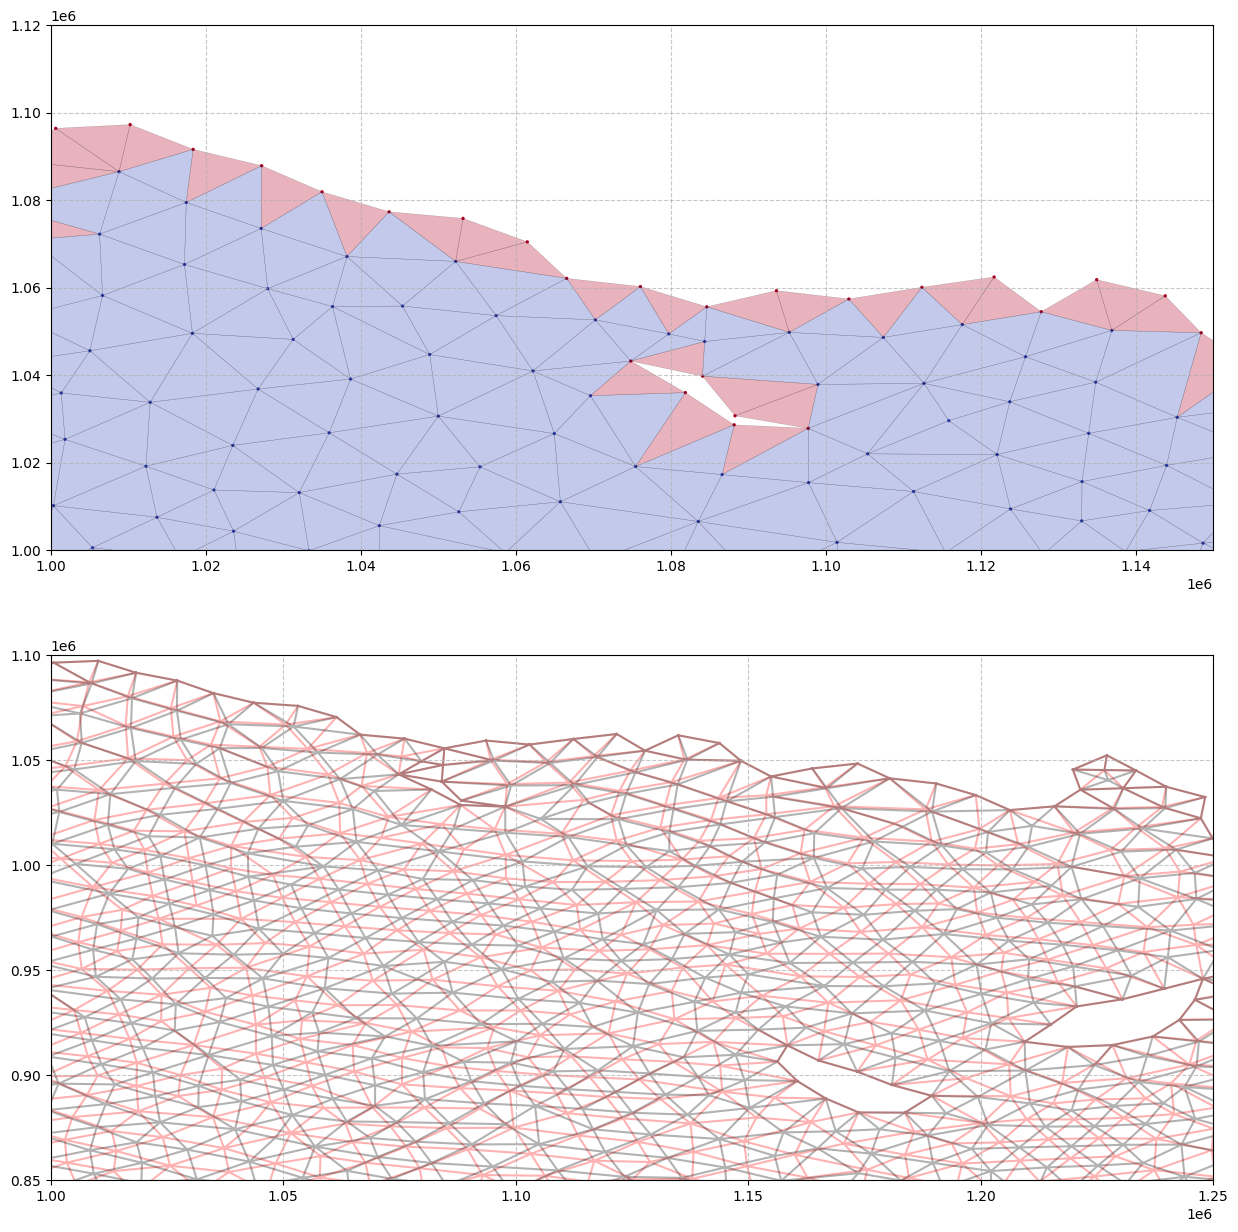

In [5]:
d0 = file_graphs[0]
d4 = file_graphs[30]

def get_position_mask(arr1, arr2):
    # Determine the length to compare
    min_length = min(len(arr1), len(arr2))
    
    # Initialize the mask with False values
    mask = [False] * len(arr1)
    
    # Compare elements up to the minimum length
    for i in range(min_length):
        if arr1[i] == arr2[i]:
            mask[i] = True
            
    return mask


#idx where d0['i'] is contained in d4['i']
mask = get_position_mask(d0['i'], d4['i'])

inerp = LinearNDInterpolator((d0['x'], d0['y']), mask )

x = (d0['x'][d0['t'][:,0]] + d0['x'][d0['t'][:,1]] + d0['x'][d0['t'][:,2]])/3
y = (d0['y'][d0['t'][:,0]] + d0['y'][d0['t'][:,1]] + d0['y'][d0['t'][:,2]])/3
mask_tri = inerp(x,y)
mask_tri = mask_tri > 0.5

fig,axs  = plt.subplots(2,1,figsize=(15,15))


axs[0].scatter(d0['x'],d0['y'],s=2,c=mask,cmap='coolwarm')

#get x,y in triangle center

im = axs[0].tripcolor(d0['x'], d0['y'], d0['t'],facecolors=mask_tri, edgecolors='k', cmap='coolwarm', alpha=0.3)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_xlim([1e6, 1.15e6])
axs[0].set_ylim([1e6, 1.12e6])


axs[1].triplot(d4['x'], d4['y'], d4['t'], color='red', alpha=0.3)
axs[1].triplot(d0['x'], d0['y'], d0['t'], color='k', alpha=0.3)

axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_xlim([1e6, 1.25e6])
axs[1].set_ylim([0.85e6, 1.1e6])

In [4]:
d0 = file_graphs[50]

for k,item in d0.items():
    print(k,item.shape)

Damage (137518,)
Concentration (137518,)
Thickness (137518,)
Sigma_0 (137518,)
Sigma_1 (137518,)
M_VT_x (70777,)
M_VT_y (70777,)
M_wind_x (70777,)
M_wind_y (70777,)
M_ocean_x (70777,)
M_ocean_y (70777,)
x (70777,)
y (70777,)
t (137518, 3)
i (70777,)


In [5]:
wind_norm = np.sqrt(d0['M_wind_x']**2 + d0['M_wind_y']**2)
wind_dir = np.arctan2(d0['M_wind_x'],d0['M_wind_y'])
ocean_norm = np.sqrt(d0['M_ocean_x']**2 + d0['M_ocean_y']**2)
ocean_dir = np.arctan2(d0['M_ocean_x'],d0['M_ocean_y'])
ice_norm = np.sqrt(d0['M_VT_x']**2 + d0['M_VT_y']**2)
ice_dir = np.arctan2(d0['M_VT_y'],d0['M_VT_y'])

nextsim =  Ice_graph([d0],vertex_element_features=['x', 'y'],d_time=1800)

interp = nextsim.get_forcings(0,['Concentration','Thickness','Damage','Sigma_0','Sigma_1'])

damage  = np.nan_to_num(interp['Damage']((d0['x'],d0['y'])))
thickness = np.nan_to_num(interp['Thickness']((d0['x'],d0['y'])))
concentration = np.nan_to_num(interp['Concentration']((d0['x'],d0['y'])))
sigma_0 = np.nan_to_num(interp['Sigma_0']((d0['x'],d0['y'])))
sigma_1 = np.nan_to_num(interp['Sigma_1']((d0['x'],d0['y'])))

In [5]:
triangles = file_graphs[0]['t']
remeshed = []
for i,graph in enumerate(file_graphs):
    if graph['t'].shape != triangles.shape:
        remeshed.append(graph)
        triangles = graph['t']

for i,graph in enumerate(remeshed):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    # Define a colormap
    cmap = plt.get_cmap('cividis')

    # Initial distribution plot
    sc0 = ax.scatter(graph['x'], graph['y'], c=graph['i'], cmap=cmap,  s=5, edgecolor='k', linewidth=0.1)
    ax.set_title('Initial Vertex IDs Distribution', fontsize=22)
    cbar0 = plt.colorbar(sc0, ax=ax, orientation='vertical')
    cbar0.set_label('Vertex ID', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    # Final distribution plot
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(f'../../figures/idx/graph_{i}.png')
    plt.close()
    

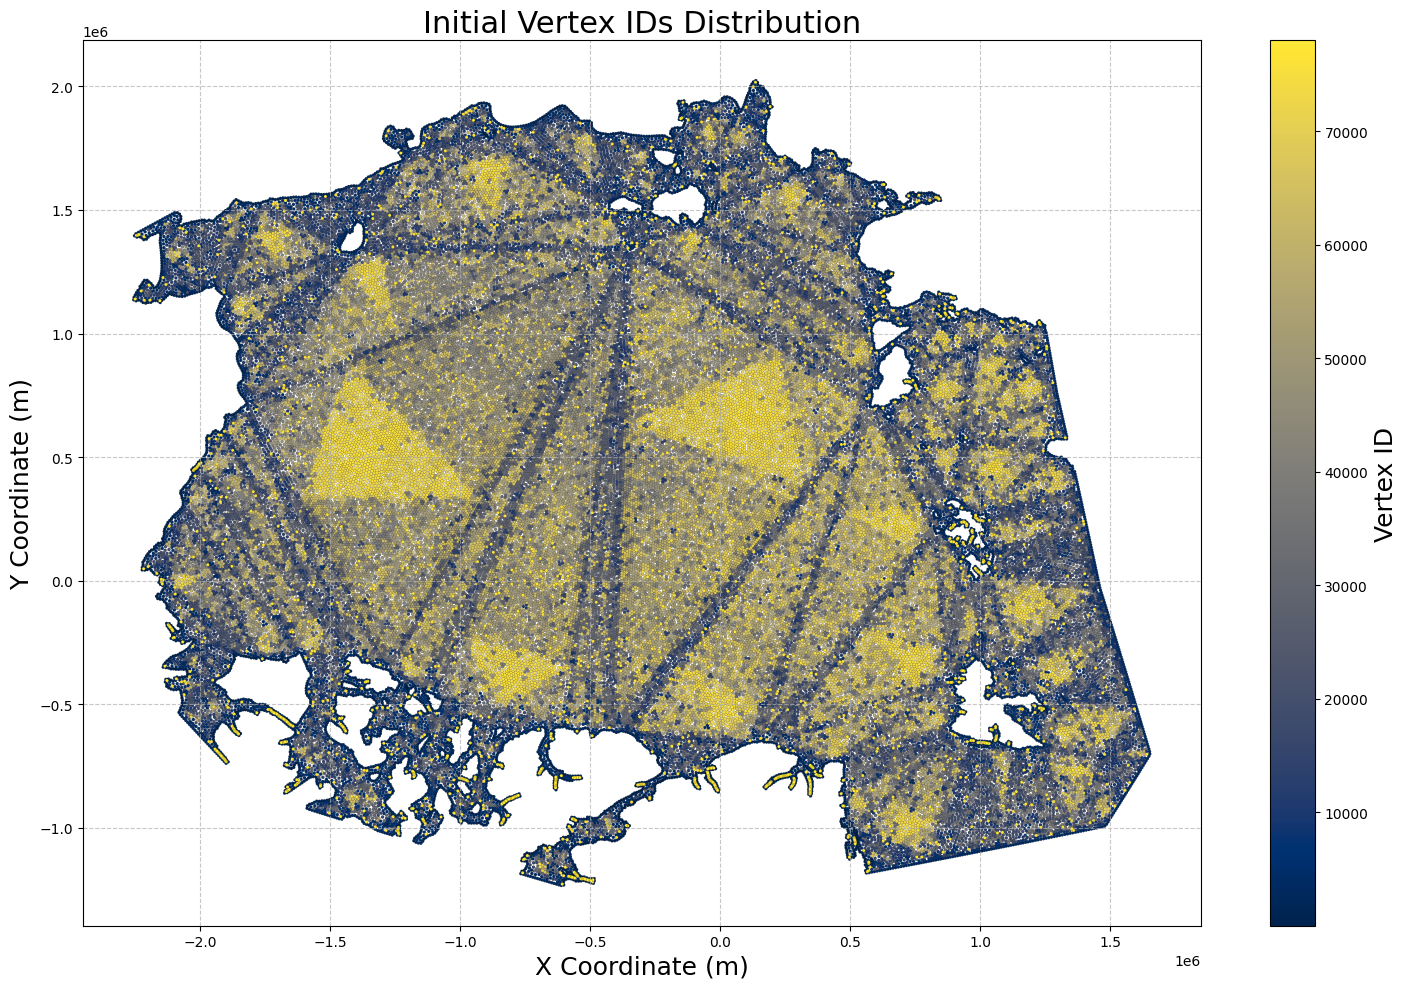

In [8]:
# Creating the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define a colormap
cmap = plt.get_cmap('cividis')

# Initial distribution plot
sc0 = ax.scatter(file0['x'], file0['y'], c=file0['i'], cmap=cmap,  s=5, edgecolor='k', linewidth=0.1)
ax.set_title('Initial Vertex IDs Distribution', fontsize=22)
ax.set_xlabel('X Coordinate (m)', fontsize=18)
ax.set_ylabel('Y Coordinate (m)', fontsize=18)
cbar0 = plt.colorbar(sc0, ax=ax, orientation='vertical')
cbar0.set_label('Vertex ID', fontsize=18)
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

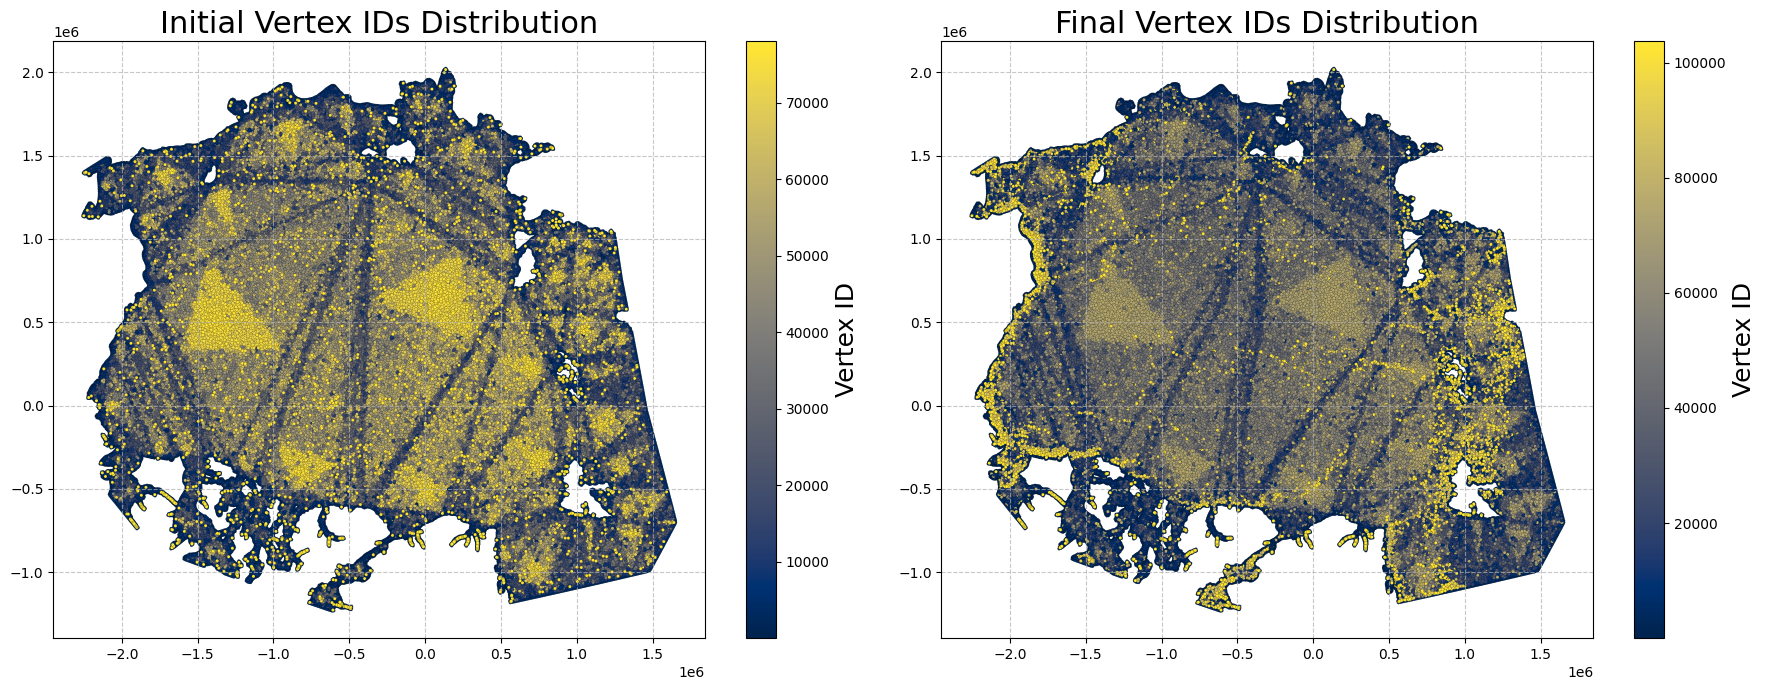

In [37]:
# Creating the plot
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Define a colormap
cmap = plt.get_cmap('cividis')

# Initial distribution plot
sc0 = ax[0].scatter(file0['x'], file0['y'], c=file0['i'], cmap=cmap,  s=5, edgecolor='k', linewidth=0.1)
ax[0].set_title('Initial Vertex IDs Distribution', fontsize=22)
cbar0 = plt.colorbar(sc0, ax=ax[0], orientation='vertical')
cbar0.set_label('Vertex ID', fontsize=18)
ax[0].grid(True, linestyle='--', alpha=0.7)
# Final distribution plot
sc1 = ax[1].scatter(file_final['x'], file_final['y'], c=file_final['i'], cmap=cmap, s=5, edgecolor='k', linewidth=0.1)
ax[1].set_title('Final Vertex IDs Distribution', fontsize=22)
ax[1].grid(True, linestyle='--', alpha=0.7)
cbar1 = plt.colorbar(sc1, ax=ax[1], orientation='vertical')
cbar1.set_label('Vertex ID', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

(65301, 1) (65301,)


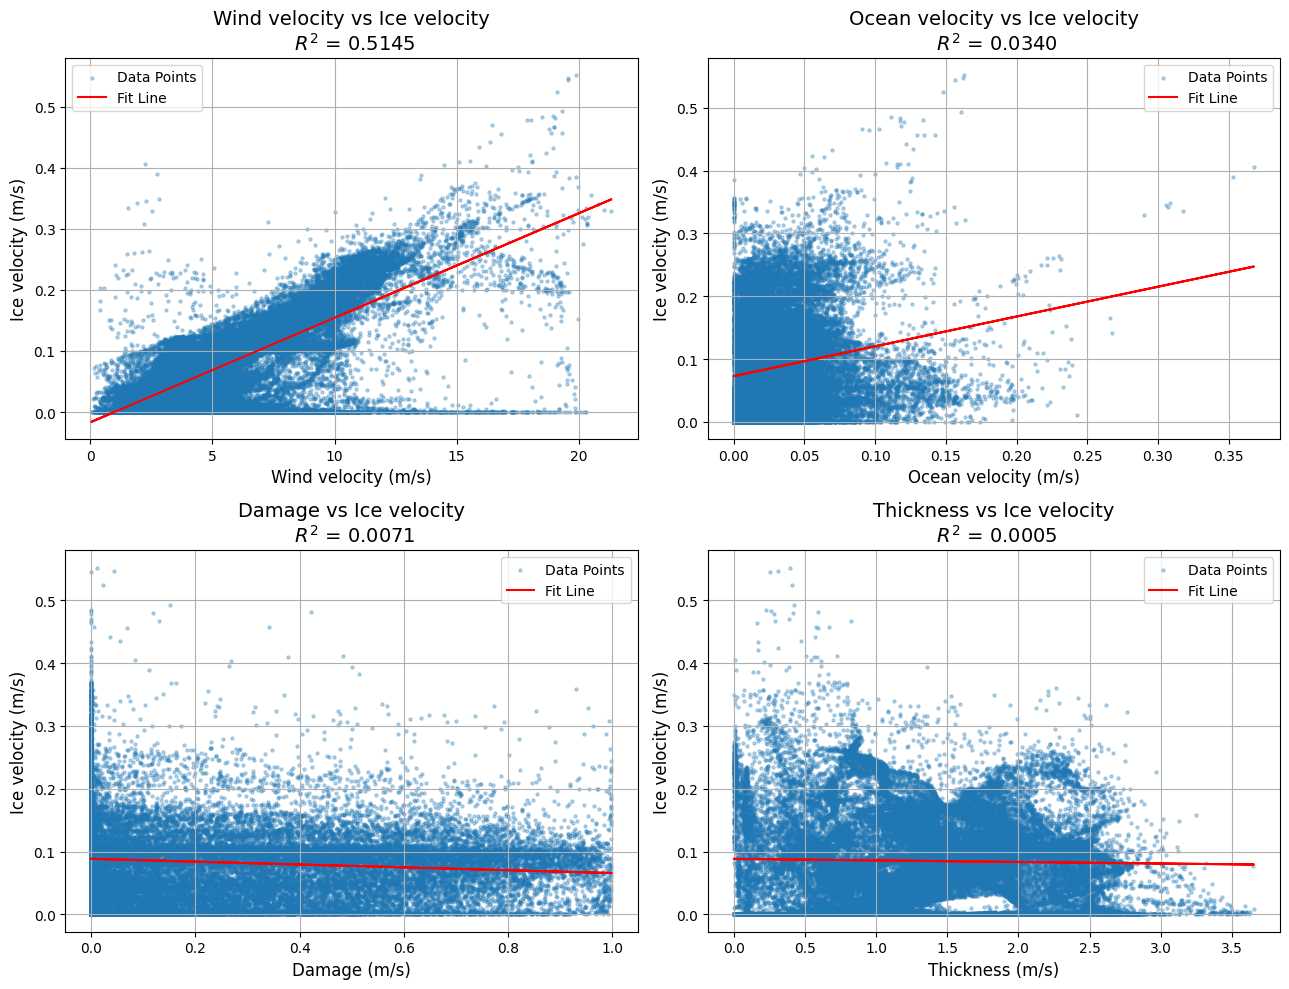

In [6]:

mask = concentration > 0 
Y = ice_norm[mask]
X_w = np.stack([wind_norm[mask]]).T
X_o = np.stack([ocean_norm[mask]]).T
X_t = np.stack([thickness[mask]]).T
X_d = np.stack([damage[mask]]).T
X_s1 = np.stack([sigma_1[mask]]).T
X_s0 = np.stack([sigma_0[mask]]).T
print(X_w.shape,Y.shape)
model_w = LinearRegression().fit(X_w,Y )
model_o = LinearRegression().fit(X_o,Y )
model_t = LinearRegression().fit(X_t,Y )
model_d = LinearRegression().fit(X_d,Y )
model_s1 = LinearRegression().fit(X_s1,Y )
model_s0 = LinearRegression().fit(X_s0,Y )
#plot in subfigures
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

# Define a list of titles and labels
titles = [
    ('Wind velocity vs Ice velocity', model_w, X_w, wind_norm),
    ('Ocean velocity vs Ice velocity', model_o, X_o, ocean_norm),
    ('Damage vs Ice velocity', model_d, X_d, damage),
    ('Thickness vs Ice velocity', model_t, X_t, thickness),
]

# Plotting each subplot
for i, (title, model, X, data) in enumerate(titles):
    row, col = divmod(i, 2)
    ax[row, col].scatter(data[mask], ice_norm[mask], s=5, alpha=0.3, label='Data Points')
    ax[row, col].plot(data[mask], model.predict(X), c='r', label='Fit Line')
    ax[row, col].set_title(f'{title}\n $R^2$ = {model.score(X, Y):.4f}', fontsize=14)
    ax[row, col].set_xlabel(f'{title.split(" vs ")[0]} (m/s)', fontsize=12)
    ax[row, col].set_ylabel('Ice velocity (m/s)', fontsize=12)
    ax[row, col].grid(True)
    ax[row, col].legend()

plt.tight_layout()
#plt.savefig('linear_regression_plots.png', dpi=300)  # Save the figure as a high-resolution image
plt.show()



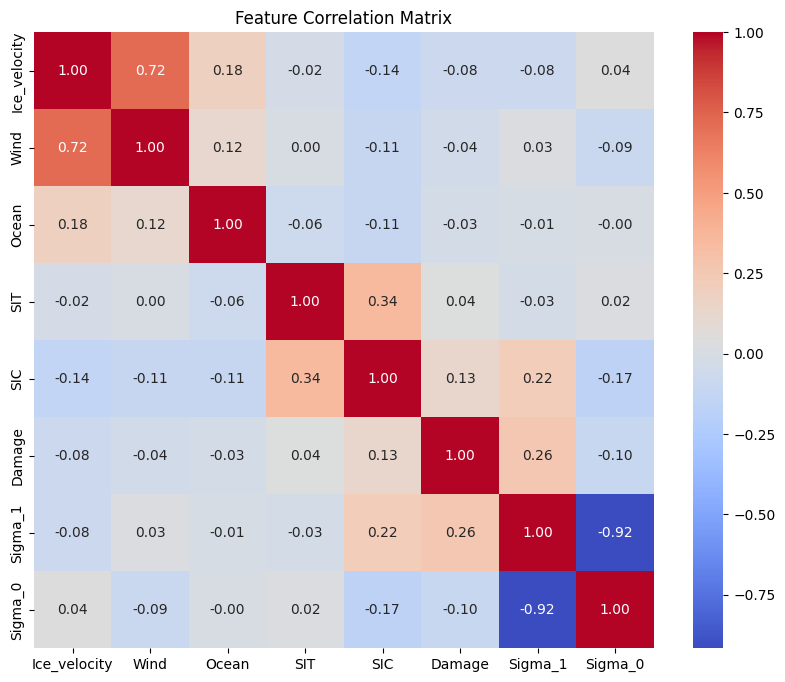

In [7]:
import seaborn as sns
import pandas as pd

# Combine all features into a DataFrame
data = {
    'Ice_velocity': ice_norm[mask],
    'Wind': wind_norm[mask],
    'Ocean': ocean_norm[mask],
    'SIT': thickness[mask],
    'SIC': concentration[mask],  
    'Damage': damage[mask],
    'Sigma_1': sigma_1[mask],
    'Sigma_0': sigma_0[mask]
}
 

df = pd.DataFrame(data)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

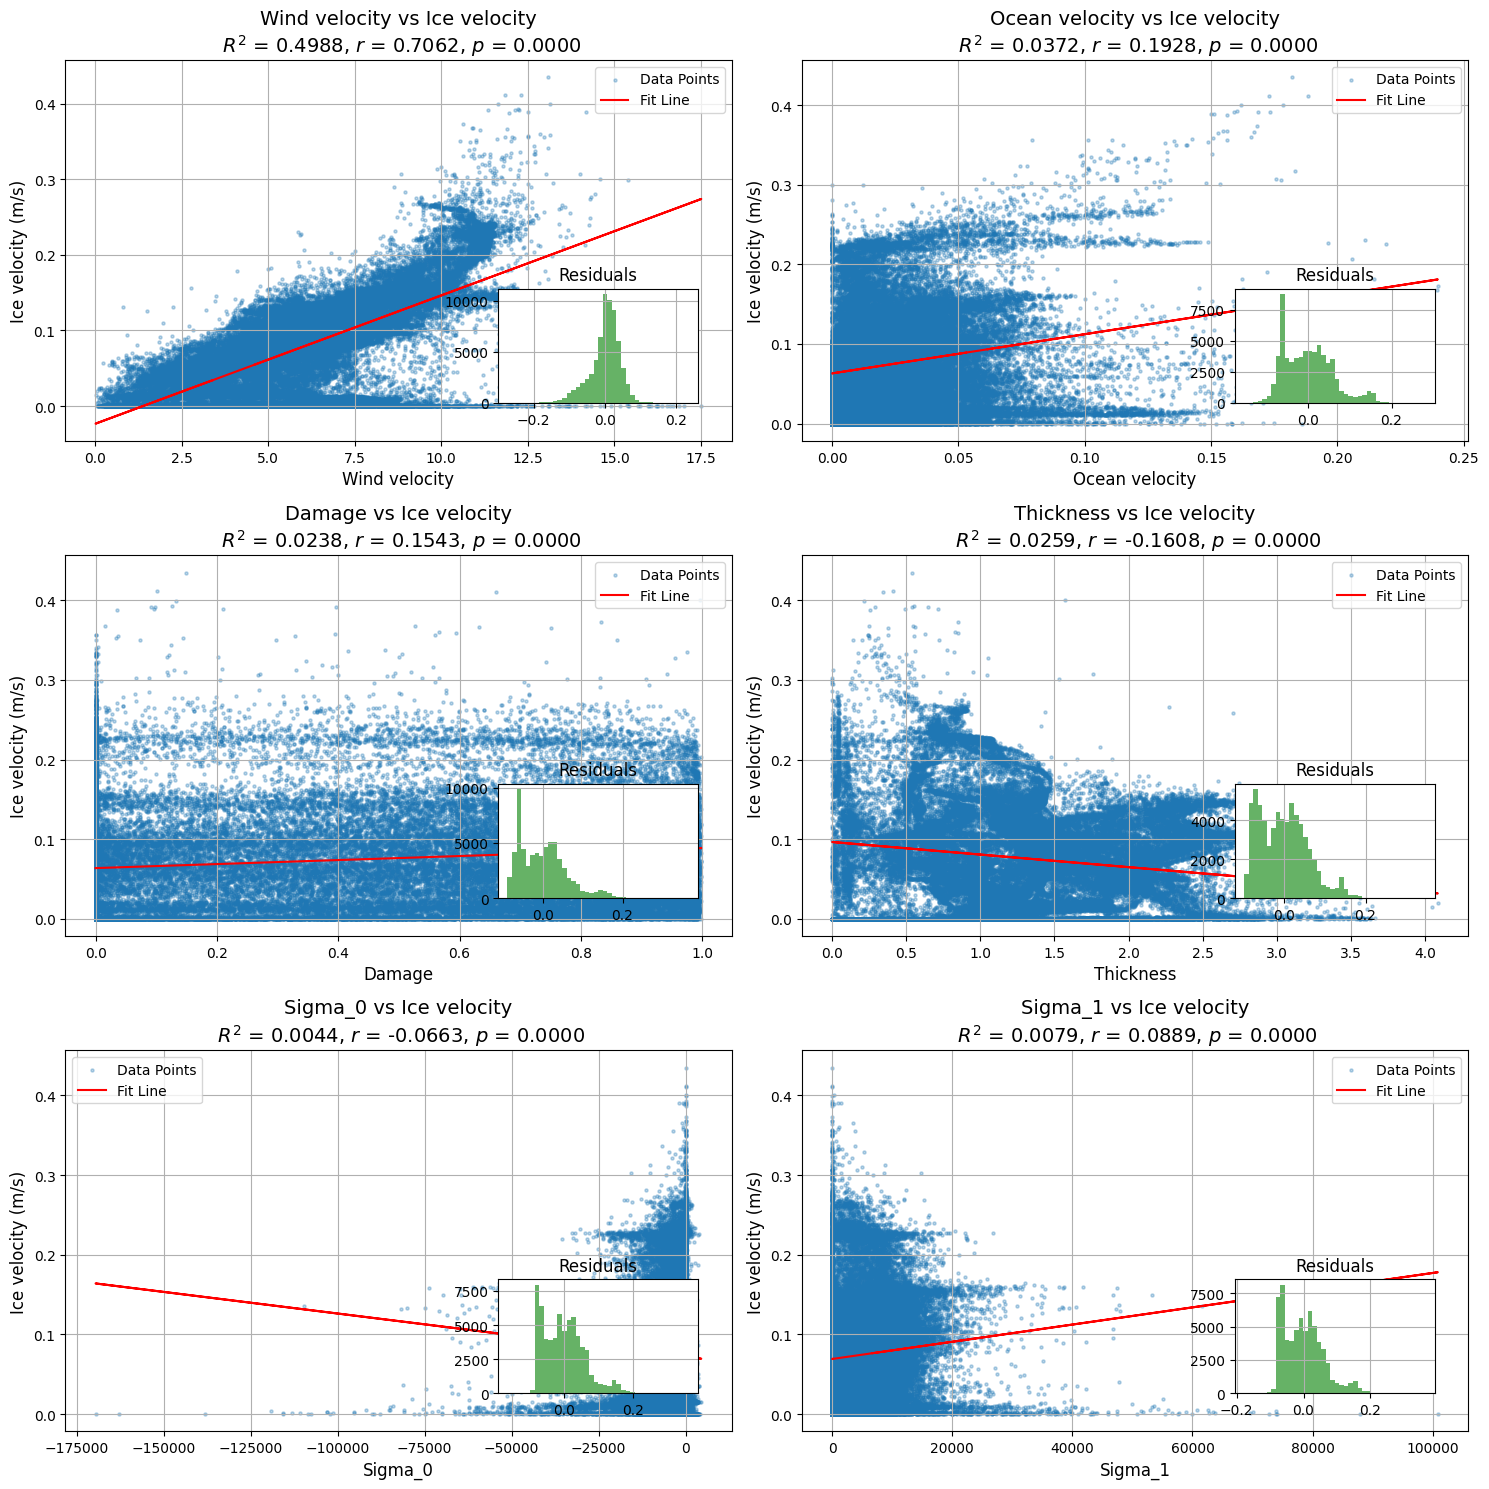

In [140]:
from scipy.stats import linregress
def calculate_corr_pval(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value, p_value


fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Plotting each subplot with histograms of residuals
for i, (title, model, X, data) in enumerate(titles):
    row, col = divmod(i, 2)
    r_value, p_value = calculate_corr_pval(data[mask], ice_norm[mask])
    ax[row, col].scatter(data[mask], ice_norm[mask], s=5, alpha=0.3, label='Data Points')
    ax[row, col].plot(data[mask], model.predict(X), c='r', label='Fit Line')
    ax[row, col].set_title(f'{title}\n $R^2$ = {model.score(X, Y):.4f}, $r$ = {r_value:.4f}, $p$ = {p_value:.4f}', fontsize=14)
    ax[row, col].set_xlabel(f'{title.split(" vs ")[0]}', fontsize=12)
    ax[row, col].set_ylabel('Ice velocity (m/s)', fontsize=12)
    ax[row, col].grid(True)
    ax[row, col].legend()
    
    # Histogram of residuals
    residuals = Y - model.predict(X)
    ax_hist = ax[row, col].inset_axes([0.65, 0.1, 0.3, 0.3])
    #put it in top corner

    ax_hist.hist(residuals, bins=40, alpha=0.6, color='g')
    ax_hist.set_title('Residuals')
    ax_hist.grid(True)

plt.tight_layout()
#plt.savefig('linear_regression_plots_with_residuals.png', dpi=300)  # Save the figure as a high-resolution image
plt.show()

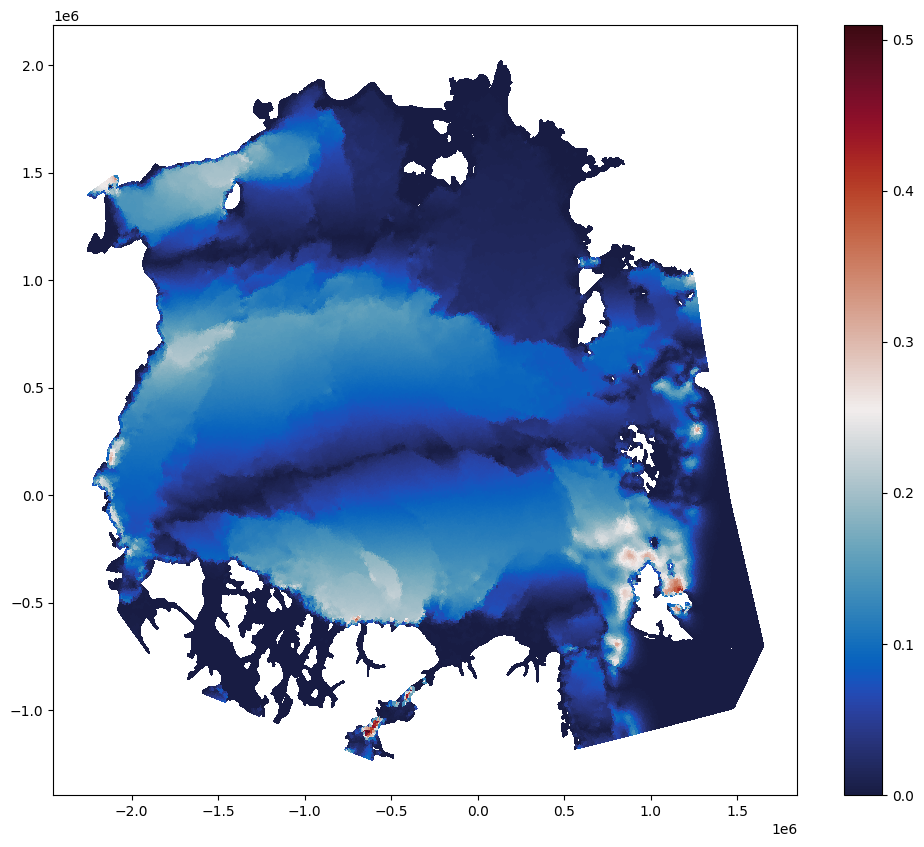

In [32]:
plt.figure(figsize=(12,10))
plt.tripcolor(d0['x'],d0['y'],d0['t'],ice_norm, cmap=cmocean.cm.balance)
plt.colorbar()